In [1]:
import numpy as np
import cv2 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import mtcnn

2024-11-22 22:51:19.601996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732308679.683423   55450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732308679.708994   55450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 22:51:19.778147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [65]:
face = extract_face('stroke/stroke6.jpg')

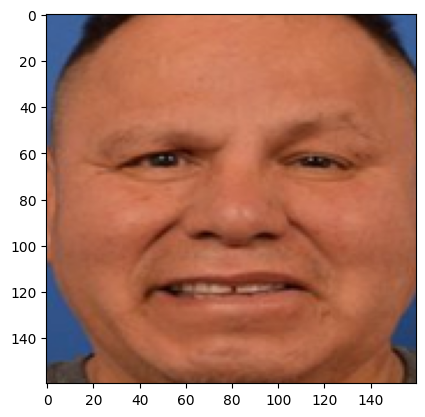

In [66]:
plt.imshow(face)

In [67]:
first_half = face[:,:80]
second_half = face[:,80:]
first_half_flip = cv2.flip(first_half,1)
second_half_flip = cv2.flip(second_half,1)
first_half_joined = np.hstack((first_half, first_half_flip))
second_half_joined = np.hstack((second_half_flip,second_half))

(-0.5, 159.5, 159.5, -0.5)

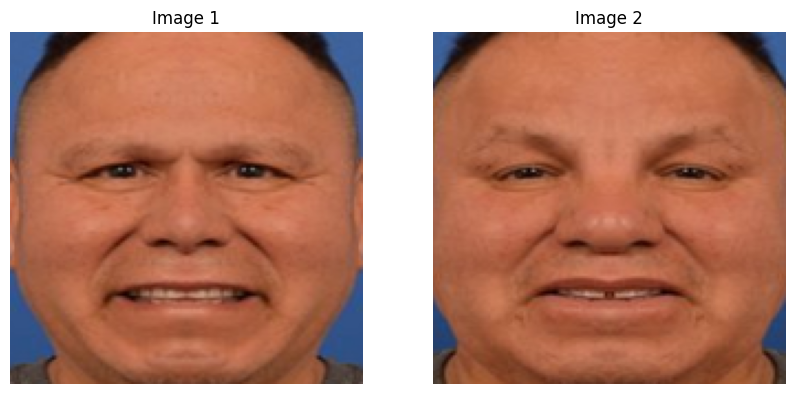

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the first image
axes[0].imshow(first_half_joined)
axes[0].set_title("Image 1")
axes[0].axis("off")  # Turn off the axis

# Display the second image
axes[1].imshow(second_half_joined)
axes[1].set_title("Image 2")
axes[1].axis("off")  # Turn off the axis

In [69]:
from transformers import AutoProcessor, AutoModelForImageClassification
from PIL import Image
import torch

In [70]:
def classify_face_expression(img):
    model_name = "trpakov/vit-face-expression"
    processor = AutoProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(model_name)
    image = Image.fromarray(img)
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
    labels = model.config.id2label

    results = {labels[i]: float(probabilities[i]) for i in range(len(labels))}
    print(results)
    maxim_emotion = max(results, key=results.get)
    if results[maxim_emotion] > 0.75:
        return maxim_emotion
    else:
        return "no emotion"

In [71]:
if classify_face_expression(first_half_joined) == classify_face_expression(second_half_joined):
    print("Normal")
else:
    print("Possibility of Stroke")

{'angry': 0.07145628333091736, 'disgust': 0.011146418750286102, 'fear': 0.036034975200891495, 'happy': 0.7150845527648926, 'neutral': 0.0638338029384613, 'sad': 0.08868344873189926, 'surprise': 0.013760501518845558}
{'angry': 0.0651765838265419, 'disgust': 0.020749378949403763, 'fear': 0.022625664249062538, 'happy': 0.650953471660614, 'neutral': 0.11697037518024445, 'sad': 0.11123421788215637, 'surprise': 0.01229042001068592}
Normal


In [72]:
classify_face_expression(first_half_joined)

{'angry': 0.07145628333091736, 'disgust': 0.011146418750286102, 'fear': 0.036034975200891495, 'happy': 0.7150845527648926, 'neutral': 0.0638338029384613, 'sad': 0.08868344873189926, 'surprise': 0.013760501518845558}


'no emotion'

In [73]:
classify_face_expression(second_half_joined)

{'angry': 0.0651765838265419, 'disgust': 0.020749378949403763, 'fear': 0.022625664249062538, 'happy': 0.650953471660614, 'neutral': 0.11697037518024445, 'sad': 0.11123421788215637, 'surprise': 0.01229042001068592}


'no emotion'